# ЛР5. Применение переноса обучения для решения задачи, поставленной во второй лабораторной работе

In [35]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [36]:
!cp /content/gdrive/'My Drive'/datasets/gtsrb-german-traffic-sign.zip .

import zipfile
with zipfile.ZipFile('gtsrb-german-traffic-sign.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

!ls

gdrive			       meta  Meta.csv	  test	Test.csv  Train
gtsrb-german-traffic-sign.zip  Meta  sample_data  Test	train	  Train.csv


In [0]:
%tensorflow_version 2.x
import os
import cv2
import numpy as np
import csv
from time import time
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
%matplotlib inline

### Описание датасета

Рассматривается задача классификации [немецких дорожных знаков](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) *GTSRB - German Traffic Sign Recognition Benchmark*.

* Train, train.csv - размеченные данные
* Test, Test.scv - тестовые данные
* Meta, Meta.csv - дополнительные данные

Для экспериментах задействованы обучающие и тестовые данные. 
Обучающая выборка содержит 43 класса.

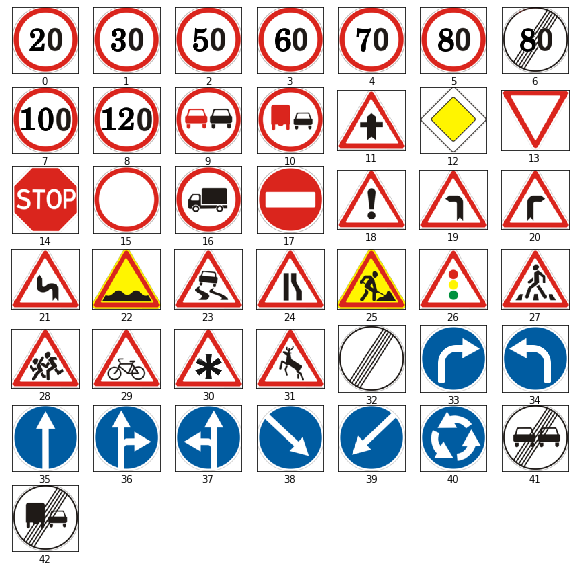

In [0]:
plt.figure(figsize=(10, 10))
for i in range (0,43):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = "meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

### Загружаем данные

In [0]:
# Предообработка данных
def preprocess(image, out_side):
	height, width = image.shape[:2]
	scale = out_side / max(height, width)
	dx = (out_side - scale * width) / 2
	dy = (out_side - scale * height) / 2
	trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
	image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
	return image

# Перемешивание данных
def mixing(images, labels):
		images = np.array(images)
		labels = np.array(labels)
		s = np.arange(images.shape[0])
		np.random.seed(43)
		np.random.shuffle(s)
		images=images[s]
		labels=labels[s]
		return images, labels

# Загрузка тренировочных данных
def load_train(path, out_side):
	images = []
	labels = []
	for folder in os.listdir(os.path.join(path, 'Train')):
		cur_path = os.path.join(path, 'Train', folder)
		for file_name in os.listdir(cur_path):
			image = cv2.imread(os.path.join(cur_path, file_name))
			images.append(preprocess(image, out_side))
			labels.append(int(folder))
	
	return mixing(images, labels)

# Загрузка тестовых данных
def load_test(path, out_side):
	images = []
	labels = []
	with open(os.path.join(path, 'Test.csv'), 'r') as f:
		reader = csv.reader(f)
		for rows in reader:
			name = rows[7]
			if (name == 'Path'):
				continue
			image = cv2.imread(os.path.join(path, rows[7]))
			images.append(preprocess(image, out_side))
			labels.append(int(rows[6]))
	
	return mixing(images, labels)

In [39]:
start = time()

# Загружаем предобработанные изображения в разрешении 50x50
train_images, train_labels = load_train(".", 50)
test_images, test_labels = load_test(".", 50)
shape = train_images[0].shape
print(shape)

# Нормализуем данные
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

# Преобразуем метки в one-hot-encoding
train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)

print('Loading: ', time() - start)

(50, 50, 3)
Loading:  10.353991508483887


### Запускаем сеть

In [0]:
def train_model(model, train_images, train_labels, test_images, test_labels, epochs, batch):
    model.summary()
    start = time()
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch)
    train_time = time() - start
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc)
    print('Time: ', train_time)

#### **Эксперимент 1**
Использование структуры глубокой модели, построенной для решения исходной «Задачи А», с целью обучения аналогичной модели для решения «Задачи В»

* Предполагается, что модель, построенная для решения исходной задачи, обучается на данных, подготовленных для решения целевой задачи
* При этом веса модели инициализируются случайным образом
* Эксперимент реализует перенос знаний для родственных доменов

Используем VGG16 - модель для решения задачи ImageNet

In [0]:
epochs, learning_rate, batch = 15, 0.001, 256

model = Sequential()
model.add(VGG16(include_top=False, input_shape=(50,50,3)))
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

adam = Adam(lr=learning_rate) 
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

train_model(model, train_images, train_labels, test_images, test_labels, epochs, batch)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_25 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_51 (Dense)             (None, 43)                44075     
Total params: 15,284,075
Trainable params: 15,284,075
Non-trainable params: 0
_________________________________________________________________
Train on 39209 samples
Epoch 1/15
39209/39209 [==============================] - 32s 828us/sample - loss: 3.1459 - accuracy: 0.1211
Epoch 2/15
39209/39209 [==============================] - 32s 815us/sample - loss: 0.9396 - accuracy: 0.707

#### **Эксперимент 2**
Использование модели, построенной для решения исходной «Задачи А», в качестве фиксированного метода извлечения признаков при построении модели, решающей «Задачу В»

* Идея данного подхода состоит в том, чтобы удалить из глубокой модели классификатор (последние полностью связанные слои) и рассматривать начальную часть сети как метод выделения признаков
* Взамен старого классификатора можно поместить новый классификатор (например, другой набор полностью связанных слоев или машину опорных векторов) и обучить его на признаках, построенных с использованием начальной части сети
* Эксперимент реализует перенос признакового описания
Возьмем за основу сверточную нейронную сеть VGG16, обученную на наборе ImageNet (1,4 миллиона изображений, классифицированных на 1000 классов).

In [44]:
epochs, learning_rate, batch = 15, 0.01, 256

base = VGG16(weights='imagenet', include_top=False, input_shape=(50,50,3))
base.trainable = False
    
model = Sequential()
model.add(base)
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
train_model(model, train_images, train_labels, test_images, test_labels, epochs, batch)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_14 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_29 (Dense)             (None, 43)                44075     
Total params: 15,284,075
Trainable params: 569,387
Non-trainable params: 14,714,688
_________________________________________________________________
Train on 39209 samples
Epoch 1/15
39209/39209 [==============================] - 11s 290us/sample - loss: 1.9625 - accuracy: 0.4365
Epoch 2/15
39209/39209 [==============================] - 11s 280us/sample - loss: 0.9827 - accuracy:

#### **Эксперимент 3**
Тонкая настройка параметров модели, построенной для решения исходной «Задачи А», с целью решения «Задачи В»

* Последние слои глубокой модели, соответствующие классификатору, который решает «Задачу А», заменяются новым классификатором (например, набором полностью связанных слоев с другим количеством выходов)
* Полученная модель обучается как единая система
* Эксперимент реализует перенос обучения на основе экземпляров

In [0]:
epochs, learning_rate, batch = 15, 0.001, 256

model = Sequential()
model.add(VGG16(weights='imagenet', include_top=False, input_shape=(50,50,3)))
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

adam = Adam(lr=learning_rate) 
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

train_model(model, train_images, train_labels, test_images, test_labels, epochs, batch)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_26 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_53 (Dense)             (None, 43)                44075     
Total params: 15,284,075
Trainable params: 15,284,075
Non-trainable params: 0
_________________________________________________________________
Train on 39209 samples
Epoch 1/15
39209/39209 [==============================] - 33s 832us/sample - loss: 3.2303 - accuracy: 0.1180
Epoch 2/15
39209/39209 [==============================] - 32s 816us/sample - loss: 1.4203 - accuracy: 0.532